#Logistic Regression
This is an example of performing logistic regression in Python with the scikit-learn module. In this example, we perform many useful python functions beyond what we need for a simple model. This is done partially to explore some more advanced modeling, array maniputation, evaluation, and so on. We will also use several external modules importing data, formatiing data, manipulating data,modeling and graphical exploration.


#Dataset
The dataset I chose for this example in Longitudinal Low Birth Weight Study (CLSLOWBWT.DAT). Hosmer and Lemeshow (2000) Applied Logistic Regression:
 Second Edition.  These data are copyrighted by John Wiley &
 Sons Inc. and must be acknowledged and used accordingly.




#List of Variables:

Variable	Description		Codes/Values		Name
______________________________________________________________________

1	Identification Code		ID Number		ID

2	Birth Number			1-4			BIRTH

3	Smoking Status 			0 = No, 1 = Yes		SMOKE
	During Pregnancy

4	Race				1 = White, 2 = Black 	RACE
					3  = Other

5	Age of Mother			Years			AGE

6	Weight of Mother at 		Pounds			LWT
	Last Menstrual Period

7	Birth Weight			Grams			BWT

8	Low Birth Weight		1 = BWT <=2500g,	LOW
					0 = BWT >2500g
________________________________________________________________________

#Problem Statement
In this example, we want to predict Low Birth Weight using the reamining dateset variables. Low Birth Weight, the dependent variable, 1 = BWT <=2500g and 0 = BWT >2500g.

#Import Modules

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

#Data Pre-Processing 

In [120]:
# load dataset
dta = pd.read_csv("C:\Users\Strickland\Documents\Python Scripts\CLSLOWBWT.csv")

#Data Exploration

In [121]:
dta.groupby('LOW').mean()

,ID,BIRTH,SMOKE,RACE,AGE,LWT,BWT
LOW,,,,,,,
0,92.875371,1.836795,0.338279,1.976261,26.163205,144.741840,3204.059347
1,95.092715,1.953642,0.536424,1.576159,27.059603,138.304636,2033.867550


We can see that on average, women who have children with a low birth weight are more likely to be smokers than nonsmokers. This makes sense based on scientific studies. Let's take another look at the Birth Number variable.

In [8]:
dta.groupby('BIRTH').mean()

,ID,SMOKE,RACE,AGE,LWT,BWT,LOW
BIRTH,,,,,,,
1,94.500000,0.393617,1.851064,22.819149,129.851064,2848.159574,0.281915
2,94.500000,0.393617,1.851064,26.930851,150.638298,2857.367021,0.303191
3,89.091837,0.408163,1.857143,31.153061,150.520408,2838.153061,0.367347
4,99.642857,0.500000,1.857143,35.500000,155.642857,2578.857143,0.357143


Low Birth Weight trends upward with more births.

#Data Visualization

In [9]:
# show plots in the notebook
%matplotlib inline

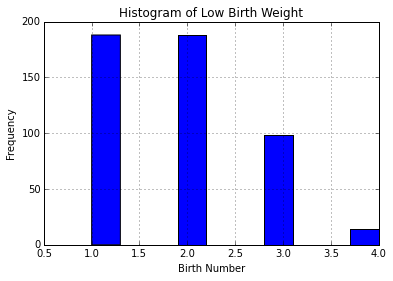

In [14]:
# histogram of birth number
dta.BIRTH.hist()
plt.title('Histogram of Low Birth Weight')
plt.xlabel('Birth Number')
plt.ylabel('Frequency')


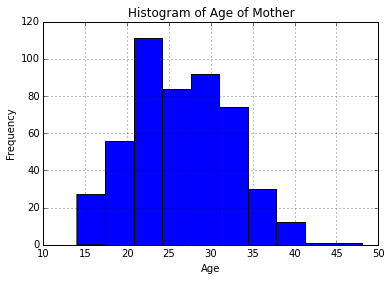

In [15]:
# histogram of age of mother
dta.AGE.hist()
plt.title('Histogram of Age of Mother')
plt.xlabel('Age')
plt.ylabel('Frequency')

Let's take a look at the distribution of smokers for those having children with low birth weights versus those who do not.

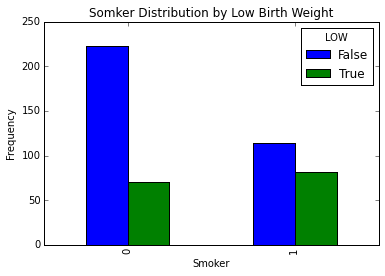

In [16]:
# barplot of low birth weights grouped by smoker status (True or False)
pd.crosstab(dta.SMOKE, dta.LOW.astype(bool)).plot(kind='bar')
plt.title('Somker Distribution by Low Birth Weight')
plt.xlabel('Smoker')
plt.ylabel('Frequency')


Now let's use a stacked barplot to look at the percentage of women having children with low birth weights by age.

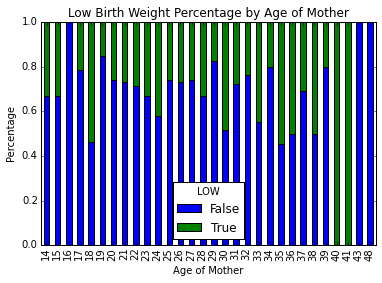

In [17]:
low_age = pd.crosstab(dta.AGE, dta.LOW.astype(bool))
low_age.div(low_age.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Low Birth Weight Percentage by Age of Mother')
plt.xlabel('Age of Mother')
plt.ylabel('Percentage')


#Prepare Data for Logistic Regression¶
To prepare the data, we want to add an intercept column as well as dummy variables for Age of Mother and Weight of Mother at Last Menstrual Period, since we are treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

The column names for the dummy variables are messy, so let's rename those.

In [193]:
# create dataframes with an intercept column and dummy variables for
y, X = dmatrices('LOW ~ ID + BIRTH + SMOKE + RACE + AGE + LWT',
                  dta, return_type="dataframe")
print X.columns

Index([u'Intercept', u'ID', u'BIRTH', u'SMOKE', u'RACE', u'AGE', u'LWT'], dtype='object')


We now want to convert the numeric (interval) variable AGE to a categorical variable with 4 classes.

We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [194]:
# flatten y into a 1-D array
y = np.ravel(y)

#First Logistic Regression¶
Let's go ahead and run logistic regression on the entire data set, and see how accurate it is.


In [195]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.70696721311475408

70.7% accuracy seems good, but what's the null error rate?

In [149]:
# what percentage had low birth weights?
y.mean()

0.3094262295081967

Only 31% of the women had low birth rate children, which means that you could obtain 69% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.
Let's examine the coefficients to see what we learn.

In [150]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.0336484036311]
1,ID,[0.00231314008486]
2,BIRTH,[0.185995251393]
3,SMOKE,[0.546655639398]
4,RACE,[-0.413795537922]
5,AGE,[0.0257483072665]
6,LWT,[-0.0115073134929]


#Coverting Variables & Merging Dataframes
Now, we want to take the varible AGE and convert it to a categorical variable, to see if we can improve the model. We will do this by creating two data frames deom our original data. we will then merge the two data frames, so both need to contain the ID variable. One data from will have the converted categorical variable age_group, and the other will have the dependent variable and the other indepedent variables.

In [205]:
df1 = pd.DataFrame(dta, columns=['ID','AGE'])
df2 = pd.DataFrame(dta, columns=['ID', 'BIRTH', 'SMOKE', 'RACE', 'LWT', 'LOW'])
bins = [15, 25, 35, 45, 55]
group_names = ['15-24', '25-34', '35-44', '45-55']
age_groups = pd.cut(df1['AGE'], bins, labels=group_names)
df1['age_groups'] = pd.cut(df1['AGE'], bins, labels=group_names)
categories
df1.head(5)

,ID,AGE,age_groups
0,1,28,25-34
1,1,33,25-34
2,2,29,25-34
3,2,34,25-34
4,2,37,35-44


We now merge the two data frames.

In [215]:
left = df2
right = df1
result = pd.merge(left, right, on='ID')
result.head(5)

,ID,BIRTH,SMOKE,RACE,LWT,LOW,AGE,age_groups
0,1,1,1,3,120,0,28,25-34
1,1,1,1,3,120,0,33,25-34
2,1,2,1,3,141,0,28,25-34
3,1,2,1,3,141,0,33,25-34
4,2,1,0,1,130,0,29,25-34


#Second Logistic Regression
We are now ready to build and evaluate our second logistic regression model, youing the merged data frames. 

In [208]:
y, Z = dmatrices('LOW ~ BIRTH + SMOKE + RACE + age_groups + LWT', result, return_type="dataframe")
print Z.columns

Index([u'Intercept', u'age_groups[T.25-34]', u'age_groups[T.35-44]',
       u'age_groups[T.45-55]', u'BIRTH', u'SMOKE', u'RACE', u'LWT'],
      dtype='object')


Since we change the size of y when we converted AGE and merged, we also need to flatten y again into a 1-D array, so that scikit-learn will properly understand it as the response variable

In [209]:
# flatten y into a 1-D array
y = np.ravel(y)

Before we perform the logistic regression, we want to check the matrix we just formed to ensure it is consistent with our intent.

In [210]:
Z.head(5)

,Intercept,age_groups[T.25-34],age_groups[T.35-44],age_groups[T.45-55],BIRTH,SMOKE,RACE,LWT
0,1,1,0,0,1,1,3,120
1,1,1,0,0,1,1,3,120
2,1,1,0,0,2,1,3,141
3,1,1,0,0,2,1,3,141
4,1,1,0,0,1,0,1,130


Finaly, we are ready to execute the logistic regresson model and see how accurate it is.

In [211]:
# instantiate a logistic regression model, and fit with X and y
model1 = LogisticRegression()
model1 = model1.fit(Z, y)

# check the accuracy on the training set
model1.score(Z, y)

0.71320754716981127

71.3% accuracy seems good, but what's the null error rate? We also want to recheck the percentage of low birth weights.

In [212]:
# what percentage had low birth weights?
y.mean()

0.30867924528301888

Still, only 31% of the women had low birth rate children, which means that you could obtain 69% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much. Let's examine the coefficients to see what we learn.

In [213]:
# examine the coefficients
pd.DataFrame(zip(Z.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.0336484036311]
1,age_groups[T.25-34],[0.00231314008486]
2,age_groups[T.35-44],[0.185995251393]
3,age_groups[T.45-55],[0.546655639398]
4,BIRTH,[-0.413795537922]
5,SMOKE,[0.0257483072665]
6,RACE,[-0.0115073134929]


Increases in Birth Number and RACE correspond to a decrease in the likelihood of having an Low Birth Weight child. A decrease in Smoking Status corresponds to a decrease in the likelihood of having an Low Birth Weight child. For Age Group, the lowest likelihood of having Low Birth Weight child corresponds to the baseline age group (15-24), since all of the dummy coefficients are positive.

#Model Evaluation Using a Validation Set¶
So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.


In [216]:
# evaluate the model by splitting into train and test sets
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(Z_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [222]:
# predict class labels for the test set
predicted = model2.predict(Z_test)
print predicted

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0

In [223]:
# generate class probabilities
probs = model2.predict_proba(Z_test)
print probs

[[ 0.70610757  0.29389243]
 [ 0.82942743  0.17057257]
 [ 0.78996271  0.21003729]
 [ 0.71714883  0.28285117]
 [ 0.82860543  0.17139457]
 [ 0.66919892  0.33080108]
 [ 0.80411336  0.19588664]
 [ 0.82942743  0.17057257]
 [ 0.80489925  0.19510075]
 [ 0.76636931  0.23363069]
 [ 0.65336844  0.34663156]
 [ 0.73297997  0.26702003]
 [ 0.78927393  0.21072607]
 [ 0.68660728  0.31339272]
 [ 0.47777583  0.52222417]
 [ 0.48227767  0.51772233]
 [ 0.65248622  0.34751378]
 [ 0.76164841  0.23835159]
 [ 0.67351301  0.32648699]
 [ 0.86128674  0.13871326]
 [ 0.76963284  0.23036716]
 [ 0.72272821  0.27727179]
 [ 0.8737568   0.1262432 ]
 [ 0.88208189  0.11791811]
 [ 0.53068538  0.46931462]
 [ 0.70610757  0.29389243]
 [ 0.7541737   0.2458263 ]
 [ 0.5221264   0.4778736 ]
 [ 0.35235687  0.64764313]
 [ 0.77792749  0.22207251]
 [ 0.88745073  0.11254927]
 [ 0.55386162  0.44613838]
 [ 0.78469494  0.21530506]
 [ 0.76285017  0.23714983]
 [ 0.911691    0.088309  ]
 [ 0.87598835  0.12401165]
 [ 0.44136563  0.55863437]
 

As you can see, the classifier is predicting a 1 (having a Low Birth Weight child) any time the probability in the second column is greater than 0.5.
Now let's generate some evaluation metrics.

In [224]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.678391959799
0.678443267259


The accuracy is 67.8%, which is the close to what we experienced when training and predicting on the same data.
We can also see the confusion matrix and a classification report with other metrics.

In [1]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

NameError: name 'metrics' is not defined

#Model Evaluation Using Cross-Validation¶
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [226]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), Z, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.53383459  0.7518797   0.69924812  0.68421053  0.64661654  0.80451128
  0.73484848  0.66666667  0.61363636  0.71755725]
0.685300951894


Looks good. It's still performing at 69% accuracy.

#Predicting the Probability of Low Birth Weight Child¶
Just for fun, let's predict the probability of a low birth weight child for a random woman not present in the dataset. She's a 35-year-old Other race, has had 2 births,(has 2 children), is a smoker,and her weight is 132.

In [228]:
model.predict_proba(np.array([0, 0, 1, 1, 3, 2, 1]))


array([[ 0.60709037,  0.39290963]])

The predicted probability of low birth weight child is 39.3%

#Next Steps¶
There are many different steps that could be tried in order to improve the model:

• including interaction terms

• removing features

• regularization techniques

• using a non-linear model